In [1]:
# Constants for you to change
import os

DATA_DIRECTORY = '/home/younes'
LIVEJOURNAL_FILENAME = os.path.join(DATA_DIRECTORY, 'web-NotreDame.txt.gz')
LIVEJOURNAL_URL = 'http://snap.stanford.edu/data/web-NotreDame.txt.gz'

# Just have these hardcoded, though we don't really need to
NUM_EDGES = 1497134
NUM_NODES = 325729

In [2]:
# Downloading the file

import urllib.request

assert os.path.exists(DATA_DIRECTORY)

# Get your data. This file is ~250M so it will take a bit
print('DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE')
if not os.path.exists(LIVEJOURNAL_FILENAME):
    urllib.request.urlretrieve(LIVEJOURNAL_URL, LIVEJOURNAL_FILENAME)

# Show a little bit of the file
print('\nFILE STATS:')
!ls -lh $LIVEJOURNAL_FILENAME
print('\nSTARTING LINES')
!zcat $LIVEJOURNAL_FILENAME | head -n 30

DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE

FILE STATS:
-rw-rw-r-- 1 younes younes 3.6M ماي 19 00:13 /home/younes/web-NotreDame.txt.gz

STARTING LINES
# Directed graph (each unordered pair of nodes is saved once): web-NotreDame.txt 
# University of Notre Dame web graph from 1999 by Albert, Jeong and Barabasi
# Nodes: 325729 Edges: 1497134
# FromNodeId	ToNodeId
0	0
0	1
0	2
0	3
0	4
0	5
0	6
0	7
0	8
0	9
0	10
0	11
0	12
0	13
0	14
0	15
0	16
1	0
1	7
1	17
1	18
1	19
1	20
1	21
1	22
1	23

gzip: stdout: Broken pipe


In [3]:
# Cleaning the data

import numpy as np
import gzip

def row_generator():
    """This will generate all the edges in the graph."""
    with gzip.open(LIVEJOURNAL_FILENAME, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            else:
                (left_node, right_node) = line.split('\t')
                yield(int(left_node), int(right_node))

def to_undirected(edge_iterable, num_edges, num_nodes, shuffle=True):
    """Takes an iterable of edges and produces the list of edges for the undirected graph.
    
    > to_undirected([[0,1],[1,2],[2,10]], 3, 11)
    array([[ 0,  1],
       [ 1,  0],
       [ 1,  2],
       [ 2,  1],
       [ 2, 10],
       [10,  2]])
    """
    # need int64 to do gross bithacks
    as_array = np.zeros((num_edges, 2), dtype=np.int64)
    for (i, (n_0, n_1)) in enumerate(edge_iterable):
            as_array[i,0] = n_0
            as_array[i,1] = n_1
    # The graph is directed, but we want to make it undirected,
    # which means we will duplicate some rows.

    left_nodes = as_array[:,0]
    right_nodes = as_array[:,1]
    
    if shuffle:
        the_shuffle = np.arange(num_nodes)
        np.random.shuffle(the_shuffle)
        left_nodes = the_shuffle.take(left_nodes)
        right_nodes = the_shuffle.take(right_nodes)

    
    # numpy.unique will not unique whole rows, so this little bit-hacking
    # is a quick way to get unique rows after making a flipped copy of
    # each edge.
    max_bits = int(np.ceil(np.log2(num_nodes + 1)))
    
    encoded_edges_forward = np.left_shift(left_nodes, max_bits) | right_nodes
    
    # Flip the columns and do it again:
    encoded_edges_reverse = np.left_shift(right_nodes, max_bits) | left_nodes

    unique_encoded_edges = np.unique(np.hstack((encoded_edges_forward, encoded_edges_reverse)))
    
    left_node_decoded = np.right_shift(unique_encoded_edges, max_bits)
    
    # Mask out the high order bits
    right_node_decoded = (2 ** (max_bits) - 1) & unique_encoded_edges
    
    undirected_edges = np.vstack((left_node_decoded, right_node_decoded)).T.astype(np.int32)

    # ascontiguousarray so that it's c-contiguous for cython code below
    return np.ascontiguousarray(undirected_edges)


def get_clean_data(shuffle=True):
    if shuffle:
        name = os.path.join(DATA_DIRECTORY, 'LJ-dame-shuffled.npy')
    else:
        name = os.path.join(DATA_DIRECTORY, 'LJ-dame.npy')

    if os.path.exists(name):
        print('Loading from file {}'.format(name))
        return np.load(name)
    else:
        print('Parsing from zip. Will write to file {}'.format(name), flush=True)
        # Lets get the edges into one big array
        edges = to_undirected(row_generator(), NUM_EDGES, NUM_NODES, shuffle=shuffle)
        print('ORIGINAL DIST: {} MIN: {} MAX: {}'.format(np.abs(edges[:,0] - edges[:,1]).mean(), edges.min(), edges.max()))
        np.save(name, edges)
        return edges

In [4]:
print("Normalizing data (or loaded pre-computed)")
%time edges = get_clean_data(shuffle=True)
%time unshuffled_edges = get_clean_data(shuffle=False)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Loading from file /home/younes/LJ-dame-shuffled.npy
CPU times: user 11.1 ms, sys: 3.11 ms, total: 14.2 ms
Wall time: 360 ms
Loading from file /home/younes/LJ-dame.npy
CPU times: user 3.76 ms, sys: 11 ms, total: 14.8 ms
Wall time: 467 ms

EDGES SHAPE: (2207671, 2)


In [5]:
def score(assignment, edges):
    """Compute the score given an assignment of vertices.
    
    N nodes are assigned to clusters 0 to K-1.
    
    assignment: Vector where N[i] is the cluster node i is assigned to.
    edges: The edges in the graph, assumed to have one in each direction
    
    Returns: (total wasted bin space, ratio of edges cut)
    """
    balance = np.bincount(assignment) / len(assignment)
    waste = (np.max(balance) - balance).sum()
    
    left_edge_assignment = assignment.take(edges[:,0])
    right_edge_assignment = assignment.take(edges[:,1])
    mismatch = (left_edge_assignment != right_edge_assignment).sum()
    cut_ratio = mismatch / len(edges)
    return (waste, cut_ratio)

In [6]:
%load_ext cython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
%%cython
import numpy as np
cimport cython

cdef int UNMAPPED = -1

def linear_deterministic_greedy(int[:,::] edges,
                                int num_nodes,
                                int num_partitions,
                                int[::] partition):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    edges: An [:,2] array of edges.
    num_nodes: The number of nodes in the graph.
    num_partitions: How many partitions we are breaking the graph into.
    partition: The partition from a previous run. Used for restreaming.

    Returns: A new partition.
    """
    # The output partition

    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)

    cdef int[::] partition_sizes = np.zeros(num_partitions, dtype=np.int32)
         
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    # Fine to be a little off, to stay integers
    cdef int partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef int max_val = 0
    cdef int val = 0
    cdef int len_edges = len(edges)
    
    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # We have found a new node so assign last_left to a partition
                
            max_arg = 0
            max_val = (partition_votes[0]) * (
                       partition_capacity - partition_sizes[0])

            for arg in range(1, num_partitions):
                val = (partition_votes[arg]) * (
                       partition_capacity - partition_sizes[arg])
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_val == 0:
                max_arg = arg
                # No neighbors (or multiple maxed out) so "randomly" select
                # the smallest partition
                for arg in range(i % num_partitions, num_partitions):
                    if partition_sizes[arg] < partition_capacity:
                        max_arg = arg
                        max_val = 1
                        break
                if max_val == 0:
                    for arg in range(0, i % num_partitions):
                        if partition_sizes[arg] < partition_capacity:
                            max_arg = arg
                            break


            partition_sizes[max_arg] += 1
            partition[last_left] = max_arg
            partition_votes[:] = 0
            last_left = left

        if partition[right] != UNMAPPED:
            partition_votes[partition[right]] += 1


    # Clean up the last assignment
    max_arg = 0
    max_val = 0
    for arg in range(0, num_partitions):
        if partition_sizes[arg] < partition_capacity:
            val = (partition_votes[arg]) * (
                    1 - partition_sizes[arg] / partition_capacity)
            if val > max_val:
                max_arg = arg
                max_val = val
    partition[left] = max_arg

    return np.asarray(partition)

In [8]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 2, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 33.3 ms, sys: 185 µs, total: 33.5 ms
Wall time: 33 ms
edge score:0.13223437731437337 waste: 3.070036748376026e-06


In [9]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 4, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 30.4 ms, sys: 430 µs, total: 30.9 ms
Wall time: 30.7 ms
edge score:0.20402677754067522 waste: 9.210110245128078e-06


In [10]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 8, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 41 ms, sys: 62 µs, total: 41 ms
Wall time: 43.9 ms
edge score:0.24822811007618437 waste: 2.1490257238437893e-05


In [11]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 16, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 65 ms, sys: 0 ns, total: 65 ms
Wall time: 64.8 ms
edge score:0.27315030183392364 waste: 4.605055122522406e-05


In [12]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 32, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 75.5 ms, sys: 0 ns, total: 75.5 ms
Wall time: 75.4 ms
edge score:0.30241281422820704 waste: 9.517113919858128e-05


In [13]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 40, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 72.9 ms, sys: 0 ns, total: 72.9 ms
Wall time: 72.5 ms
edge score:0.3458359510995977 waste: 0.0009547814287336163


In [14]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('Wasted Bins: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel(' edges cut')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title('Score: {} partitions'.format(num_partitions))
    
    fig.tight_layout()

In [15]:
def run_restreaming_greedy(edges, num_nodes, num_partitions=10, num_iterations=10):
    print('\n{} PARTITIONS'.format(num_partitions))
    assignments = None
    print('ROUND\tWASTE\tSCORE')
    waste_values = []
    edge_score_values = []
    flipped_edges = numpy.flipud(edges).copy()
    for i in range(num_iterations):
        assignments = linear_deterministic_greedy(edges, NUM_NODES, num_partitions, assignments)
        (waste, edge_score) = score(assignments, edges)
        waste_values.append(waste)
        edge_score_values.append(edge_score)
        print('{}\t{:0.3f}\t{:0.3f}'.format(i, waste, edge_score))
    draw_figures(waste_values, edge_score_values, num_partitions)


2 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.132
1	0.000	0.055
2	0.000	0.048
3	0.000	0.048
4	0.000	0.047
5	0.000	0.046
6	0.000	0.045
7	0.000	0.045
8	0.000	0.045
9	0.000	0.045
10	0.000	0.045
11	0.000	0.045
12	0.000	0.045
13	0.000	0.045
14	0.000	0.045
15	0.000	0.045
16	0.000	0.045
17	0.000	0.045
18	0.000	0.045
19	0.000	0.045
CPU times: user 1.19 s, sys: 284 ms, total: 1.47 s
Wall time: 1.38 s


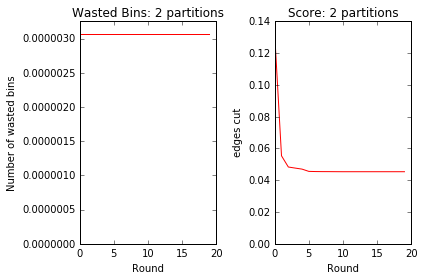

In [16]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=2, num_iterations=20)



4 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.204
1	0.000	0.091
2	0.000	0.083
3	0.000	0.080
4	0.000	0.079
5	0.000	0.078
6	0.000	0.078
7	0.000	0.078
8	0.000	0.078
9	0.000	0.078
10	0.000	0.078
11	0.000	0.077
12	0.000	0.077
13	0.000	0.077
14	0.000	0.077
15	0.000	0.077
16	0.000	0.077
17	0.000	0.077
18	0.000	0.077
19	0.000	0.077
CPU times: user 1.25 s, sys: 258 ms, total: 1.51 s
Wall time: 1.43 s


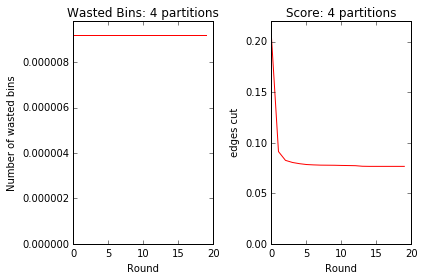

In [17]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=4, num_iterations=20)



8 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.248
1	0.000	0.109
2	0.000	0.097
3	0.000	0.094
4	0.000	0.093
5	0.000	0.092
6	0.000	0.092
7	0.000	0.092
8	0.000	0.092
9	0.000	0.092
10	0.000	0.092
11	0.000	0.092
12	0.000	0.092
13	0.000	0.092
14	0.000	0.092
15	0.000	0.092
16	0.000	0.092
17	0.000	0.092
18	0.000	0.092
19	0.000	0.092
CPU times: user 1.36 s, sys: 239 ms, total: 1.6 s
Wall time: 1.49 s


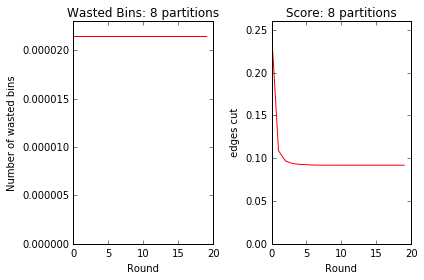

In [18]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=8, num_iterations=20)



16 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.273
1	0.000	0.140
2	0.000	0.112
3	0.000	0.109
4	0.000	0.105
5	0.000	0.104
6	0.000	0.103
7	0.000	0.102
8	0.000	0.101
9	0.000	0.101
10	0.000	0.101
11	0.000	0.101
12	0.000	0.101
13	0.000	0.101
14	0.000	0.101
15	0.000	0.101
16	0.000	0.101
17	0.000	0.101
18	0.000	0.101
19	0.000	0.101
CPU times: user 1.51 s, sys: 95.8 ms, total: 1.6 s
Wall time: 1.51 s


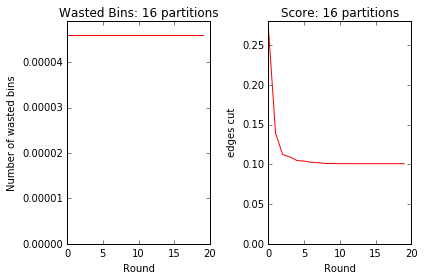

In [19]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=16, num_iterations=20)



32 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.302
1	0.000	0.158
2	0.000	0.124
3	0.000	0.121
4	0.000	0.117
5	0.000	0.116
6	0.000	0.115
7	0.000	0.115
8	0.000	0.115
9	0.000	0.115
10	0.000	0.115
11	0.000	0.115
12	0.000	0.115
13	0.000	0.115
14	0.000	0.115
15	0.000	0.115
16	0.000	0.115
17	0.000	0.115
18	0.000	0.115
19	0.000	0.115
CPU times: user 1.8 s, sys: 122 ms, total: 1.92 s
Wall time: 1.79 s


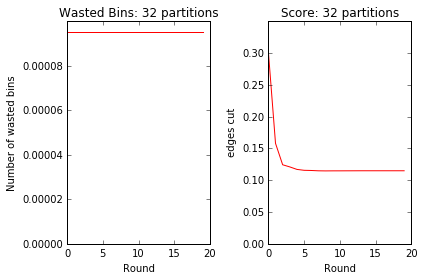

In [20]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=32, num_iterations=20)



40 PARTITIONS
ROUND	WASTE	SCORE
0	0.001	0.346
1	0.001	0.159
2	0.001	0.132
3	0.001	0.130
4	0.001	0.126
5	0.001	0.128
6	0.001	0.124
7	0.001	0.126
8	0.001	0.122
9	0.001	0.124
10	0.001	0.122
11	0.001	0.124
12	0.001	0.122
13	0.001	0.124
14	0.001	0.122
15	0.001	0.124
16	0.001	0.122
17	0.001	0.124
18	0.001	0.122
19	0.001	0.124
CPU times: user 2.03 s, sys: 103 ms, total: 2.14 s
Wall time: 2 s


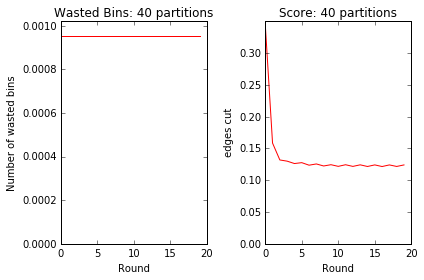

In [21]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=40, num_iterations=20)


In [22]:
%%cython
import numpy as np

cdef int UNMAPPED = -1

def fennel(int[:,::] edges,
           int num_nodes,
           int num_partitions,
           int[::] partition,
           float alpha):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    partition: A previous partition of the nodes. Set to -1's if a node has not been assigned.
    """
    
    cdef int[::] partition_sizes = None
    # The output partition
    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)
        partition_sizes = np.zeros(num_partitions, dtype=np.int32)
    else:
        partition_sizes = np.bincount(partition).astype(np.int32)
    
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    cdef float partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef float max_val = 0
    cdef float val = 0
    cdef int len_edges = len(edges)
    cdef int previous_assignment = 0

    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # New left node, so we have to assign last left

            # Remember placement of last_left in the previous assignment
            previous_assignment = partition[last_left]
            
            max_arg = 0
            max_val = partition_votes[0] - alpha * partition_sizes[0]
            if previous_assignment == 0:
                # We remove the node from its current partition before
                # deciding to re-add it, so subtract alpha to give
                # result of 1 lower partition size.
                max_val += alpha

            for arg in range(1, num_partitions):
                val = partition_votes[arg] - alpha * partition_sizes[arg]
                if previous_assignment == arg:
                    # See comment above
                    val += alpha
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_arg != previous_assignment:
                partition[last_left] = max_arg
                partition_sizes[max_arg] += 1
                if previous_assignment != UNMAPPED:
                    partition_sizes[previous_assignment] -= 1

            partition_votes[:] = 0
            last_left = left

        if partition[right] != -1:
            partition_votes[partition[right]] += 1
    
    # TODO: finish off this fencepost....
    partition[left] = 0
    
    return np.asarray(partition)

In [24]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 44.8 ms, sys: 196 µs, total: 45 ms
Wall time: 44.6 ms
wast=1.0000030700367484 edge cut = 0.1555720938491288


In [26]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.000000015)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 48.5 ms, sys: 71 µs, total: 48.5 ms
Wall time: 48.3 ms
wast=1.0000092101102451 edge cut = 0.24511442148762203


In [27]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,8,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 54.3 ms, sys: 0 ns, total: 54.3 ms
Wall time: 54.1 ms
wast=1.0000214902572384 edge cut = 0.2927682612128347


In [28]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,16,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 63.8 ms, sys: 0 ns, total: 63.8 ms
Wall time: 63.3 ms
wast=1.0000951711391985 edge cut = 0.3185519943868448


In [29]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,32,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 82.2 ms, sys: 570 µs, total: 82.7 ms
Wall time: 82.2 ms
wast=1.0000951711391985 edge cut = 0.33770339874012023


In [30]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,40,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 108 ms
wast=1.0000951711391985 edge cut = 0.340804404279442


In [27]:
def run_fennel_restreaming(edges, num_nodes, num_partitions, num_iterations):
    print('{} PARTITIONS'.format(num_partitions))
    assignments = None
    # We will explore this parameter in a future post. This is sub-optimal
    alphas = np.linspace(1.251608191745264e-10, 7.588951557309824e-2, num_iterations)
    waste_scores, edge_score_values = [], []
    print('ROUND\tALPHA\tWASTE\tSCORE')
    for i in range(num_iterations):
        alpha = alphas[i]
        assignments = fennel(edges, NUM_NODES, num_partitions, assignments, 1.)
        (waste, edge_score) = score(assignments, edges)
        print('{}\t{:.1e}\t{:0.3f}\t{:0.3f}'.format(i, alpha, waste, edge_score))
        waste_scores.append(waste)
        edge_score_values.append(edge_score)
    draw_figures(waste_scores, edge_score_values, num_partitions)

# K = 2

2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.156
1	5.5e-06	0.000	0.087
2	1.1e-05	0.000	0.072
3	1.6e-05	0.000	0.066
4	2.2e-05	0.000	0.063
5	2.7e-05	0.000	0.060
6	3.3e-05	0.000	0.059
7	3.8e-05	0.000	0.058
8	4.3e-05	0.000	0.057
9	4.9e-05	0.000	0.056
10	5.4e-05	0.000	0.056
11	6.0e-05	0.000	0.056
12	6.5e-05	0.000	0.056
13	7.0e-05	0.000	0.055
14	7.6e-05	0.000	0.055
CPU times: user 1.24 s, sys: 78 ms, total: 1.32 s
Wall time: 1.17 s


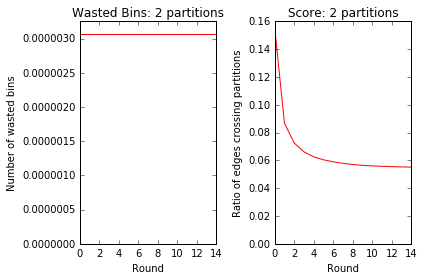

In [36]:
%time run_fennel_restreaming(edges, NUM_NODES, 2, 15)


2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-10	0.000	0.156
1	4.0e-03	0.000	0.087
2	8.0e-03	0.000	0.072
3	1.2e-02	0.000	0.066
4	1.6e-02	0.000	0.063
5	2.0e-02	0.000	0.060
6	2.4e-02	0.000	0.059
7	2.8e-02	0.000	0.058
8	3.2e-02	0.000	0.057
9	3.6e-02	0.000	0.056
10	4.0e-02	0.000	0.056
11	4.4e-02	0.000	0.056
12	4.8e-02	0.000	0.056
13	5.2e-02	0.000	0.055
14	5.6e-02	0.000	0.055
15	6.0e-02	0.000	0.055
16	6.4e-02	0.000	0.055
17	6.8e-02	0.000	0.055
18	7.2e-02	0.000	0.055
19	7.6e-02	0.000	0.055
CPU times: user 1.69 s, sys: 92 ms, total: 1.78 s
Wall time: 1.64 s


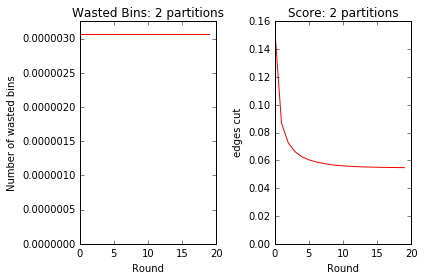

In [28]:
%time run_fennel_restreaming(edges, NUM_NODES, 2, 20)


# K =4

4 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.245
1	5.5e-06	0.000	0.144
2	1.1e-05	0.000	0.120
3	1.6e-05	0.000	0.109
4	2.2e-05	0.000	0.103
5	2.7e-05	0.000	0.099
6	3.3e-05	0.000	0.095
7	3.8e-05	0.000	0.093
8	4.3e-05	0.000	0.091
9	4.9e-05	0.000	0.090
10	5.4e-05	0.000	0.088
11	6.0e-05	0.000	0.087
12	6.5e-05	0.000	0.087
13	7.0e-05	0.000	0.086
14	7.6e-05	0.000	0.085
CPU times: user 1.27 s, sys: 140 ms, total: 1.41 s
Wall time: 1.2 s


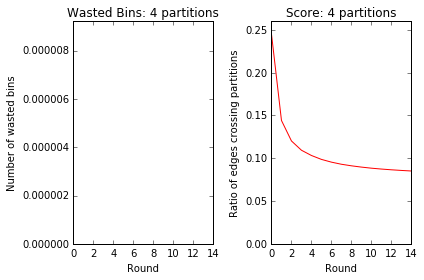

In [37]:
%time run_fennel_restreaming(edges, NUM_NODES, 4, 15)


4 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-10	0.000	0.245
1	4.0e-03	0.000	0.144
2	8.0e-03	0.000	0.120
3	1.2e-02	0.000	0.109
4	1.6e-02	0.000	0.103
5	2.0e-02	0.000	0.099
6	2.4e-02	0.000	0.095
7	2.8e-02	0.000	0.093
8	3.2e-02	0.000	0.091
9	3.6e-02	0.000	0.090
10	4.0e-02	0.000	0.088
11	4.4e-02	0.000	0.087
12	4.8e-02	0.000	0.087
13	5.2e-02	0.000	0.086
14	5.6e-02	0.000	0.085
15	6.0e-02	0.000	0.084
16	6.4e-02	0.000	0.084
17	6.8e-02	0.000	0.083
18	7.2e-02	0.000	0.083
19	7.6e-02	0.000	0.082
CPU times: user 1.71 s, sys: 78.1 ms, total: 1.79 s
Wall time: 1.66 s


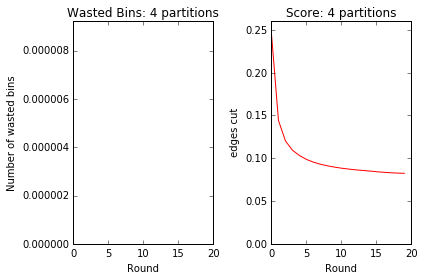

In [29]:
%time run_fennel_restreaming(edges, NUM_NODES, 4, 20)


# K =8

8 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-10	0.000	0.293
1	4.0e-03	0.000	0.174
2	8.0e-03	0.000	0.147
3	1.2e-02	0.000	0.134
4	1.6e-02	0.000	0.126
5	2.0e-02	0.000	0.121
6	2.4e-02	0.000	0.117
7	2.8e-02	0.000	0.115
8	3.2e-02	0.000	0.112
9	3.6e-02	0.000	0.111
10	4.0e-02	0.000	0.109
11	4.4e-02	0.000	0.108
12	4.8e-02	0.000	0.107
13	5.2e-02	0.000	0.106
14	5.6e-02	0.000	0.106
15	6.0e-02	0.000	0.105
16	6.4e-02	0.000	0.105
17	6.8e-02	0.000	0.104
18	7.2e-02	0.000	0.104
19	7.6e-02	0.000	0.103
CPU times: user 1.87 s, sys: 87.1 ms, total: 1.96 s
Wall time: 1.84 s


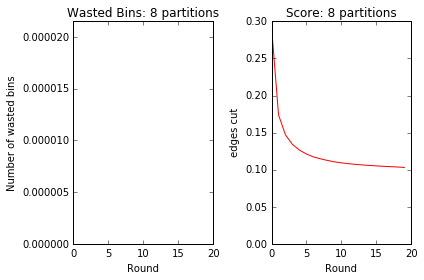

In [30]:
%time run_fennel_restreaming(edges, NUM_NODES, 8, 20)


# K =16

16 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-10	0.000	0.319
1	4.0e-03	0.000	0.192
2	8.0e-03	0.000	0.163
3	1.2e-02	0.000	0.150
4	1.6e-02	0.000	0.142
5	2.0e-02	0.000	0.137
6	2.4e-02	0.000	0.133
7	2.8e-02	0.000	0.130
8	3.2e-02	0.000	0.128
9	3.6e-02	0.000	0.126
10	4.0e-02	0.000	0.124
11	4.4e-02	0.000	0.123
12	4.8e-02	0.000	0.121
13	5.2e-02	0.000	0.120
14	5.6e-02	0.000	0.119
15	6.0e-02	0.000	0.119
16	6.4e-02	0.000	0.118
17	6.8e-02	0.000	0.118
18	7.2e-02	0.000	0.117
19	7.6e-02	0.000	0.117
CPU times: user 2.01 s, sys: 56.7 ms, total: 2.07 s
Wall time: 1.98 s


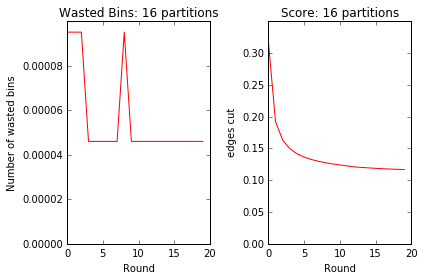

In [31]:
%time run_fennel_restreaming(edges, NUM_NODES, 16, 20)


# K =32

32 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-10	0.000	0.338
1	4.0e-03	0.000	0.207
2	8.0e-03	0.000	0.177
3	1.2e-02	0.000	0.162
4	1.6e-02	0.000	0.154
5	2.0e-02	0.000	0.148
6	2.4e-02	0.000	0.144
7	2.8e-02	0.000	0.141
8	3.2e-02	0.000	0.138
9	3.6e-02	0.000	0.136
10	4.0e-02	0.000	0.134
11	4.4e-02	0.000	0.133
12	4.8e-02	0.000	0.131
13	5.2e-02	0.000	0.130
14	5.6e-02	0.000	0.130
15	6.0e-02	0.000	0.129
16	6.4e-02	0.000	0.129
17	6.8e-02	0.000	0.128
18	7.2e-02	0.000	0.128
19	7.6e-02	0.000	0.127
CPU times: user 2.5 s, sys: 98 ms, total: 2.6 s
Wall time: 2.45 s


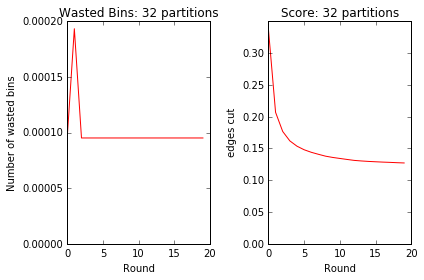

In [32]:
%time run_fennel_restreaming(edges, NUM_NODES, 32, 20)


# K =40

40 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-10	0.000	0.341
1	4.0e-03	0.000	0.210
2	8.0e-03	0.000	0.180
3	1.2e-02	0.000	0.166
4	1.6e-02	0.000	0.157
5	2.0e-02	0.000	0.151
6	2.4e-02	0.000	0.147
7	2.8e-02	0.000	0.144
8	3.2e-02	0.000	0.141
9	3.6e-02	0.000	0.140
10	4.0e-02	0.000	0.138
11	4.4e-02	0.000	0.137
12	4.8e-02	0.000	0.136
13	5.2e-02	0.000	0.135
14	5.6e-02	0.000	0.134
15	6.0e-02	0.000	0.134
16	6.4e-02	0.000	0.133
17	6.8e-02	0.000	0.133
18	7.2e-02	0.000	0.132
19	7.6e-02	0.000	0.132
CPU times: user 2.45 s, sys: 85.4 ms, total: 2.54 s
Wall time: 2.42 s


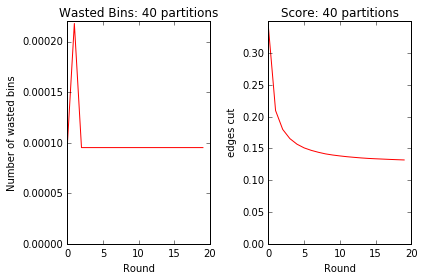

In [33]:
%time run_fennel_restreaming(edges, NUM_NODES, 40, 20)
